In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import h5py
import matplotlib.pyplot as plt
import seaborn as sns

from keras.models import load_model
from pathlib import Path

from ml_tb.normalisation import MinMaxScaler
from ml_tb.metrics import RMSE_denormalised_P, RMSE_denormalised_T

C:\Users\ThinkPad\AppData\Local\Temp\ipykernel_2220\856416513.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# Load model

In [2]:
# define the custom metrics
scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0)
inv_scaling_pt = MinMaxScaler(min=[1500, 400], max=[10000, 900], axis=0, invert=True)

def RMSE_P(y_true, y_pred):
    return RMSE_denormalised_P(y_true, y_pred, inv_scaling_pt)


def RMSE_T(y_true, y_pred):
    return RMSE_denormalised_T(y_true, y_pred, inv_scaling_pt)

In [3]:
model = load_model(Path("..","03_transfer_learning", "saved_models", "03a_BtThermobarometer_finetuning"), compile=False)
model.compile(optimizer="adam", loss="mean_squared_error", metrics=[RMSE_T, RMSE_P])
model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 64)                448       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                     

# Load data

In [4]:
# load excel file
data = pd.read_excel(Path("..","01_fit_natural_biotite","Metapelite-Database_Bt_CLEAN_2024-02-03.xlsx"))

biotite_composition = np.zeros(shape=(len(data), 6))
biotite_composition[:, 0] = data["Bt-Si"]
biotite_composition[:, 1] = data["Bt-Ti"]
biotite_composition[:, 2] = data["Bt-Al"]
biotite_composition[:, 3] = data["Bt-FeTot"]
biotite_composition[:, 4] = data["Bt-Mn"]
biotite_composition[:, 5] = data["Bt-Mg"]

pt = np.zeros(shape=(len(data), 2))
pt[:, 0] = data["Pressure estimate random uniform"] * 1000 # convert to bar
pt[:, 1] = data["Temperature random ordered after Ti-in-Bt"]

# check for NaN values (should be already filtered out)
print("NaN values in biotite composition: ", np.isnan(biotite_composition).any())
print("NaN values in PT: ", np.isnan(pt).any())

NaN values in biotite composition:  False
NaN values in PT:  False


In [5]:
def gradient(model, data):
    # Conver the data to a tensor
    data = tf.convert_to_tensor(data)

    with tf.GradientTape(persistent=True) as tape:
        tape.watch(data)
        pressure_pred = inv_scaling_pt(model(data))[:, 0]
        temperature_pred = inv_scaling_pt(model(data))[:, 1]

    return tape.gradient(pressure_pred, data).numpy(), tape.gradient(temperature_pred, data).numpy()

# Calculate the gradient

In [6]:
grads_P, grads_T = gradient(model, biotite_composition)

Additionally the directional derivative is calculated for a "unit vector" in along each of the compositional dimensions. This can be used a normalisation, taking into acount the scale of the compositional dimensions.

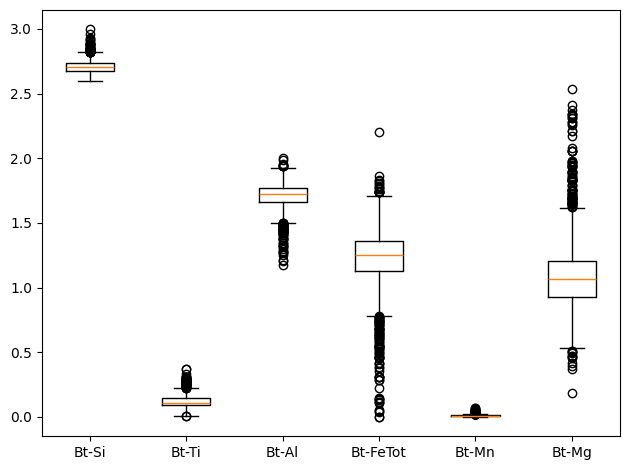

In [7]:
fig, ax = plt.subplots()

ax.boxplot(biotite_composition, showfliers=True)
ax.set_xticklabels(["Bt-Si", "Bt-Ti", "Bt-Al", "Bt-FeTot", "Bt-Mn", "Bt-Mg"])


fig.tight_layout()

In [8]:
(np.quantile(biotite_composition, 0.75, axis=0) - np.quantile(biotite_composition, 0.25, axis=0)) *0.1

array([0.00584284, 0.00550607, 0.01074218, 0.02326886, 0.00072686,
       0.02747275])

In [9]:
unit_vector = np.zeros(6)

# for each dim take 10% of the iqr of the entries in the compositional data
unit_vector = (np.quantile(biotite_composition, 0.75, axis=0) - np.quantile(biotite_composition, 0.25, axis=0)) *0.1

# calculate the product of the gradient and the unit vector
dir_grad_P = np.zeros((len(data), 6))
dir_grad_T = np.zeros((len(data), 6))

for i in range(len(data)):
    dir_grad_P[i] = grads_P[i] * unit_vector
    dir_grad_T[i] = grads_T[i] * unit_vector

## Plot 1: Boxplots (?) for each element in input vector, two plots one for pressure and one for temperature

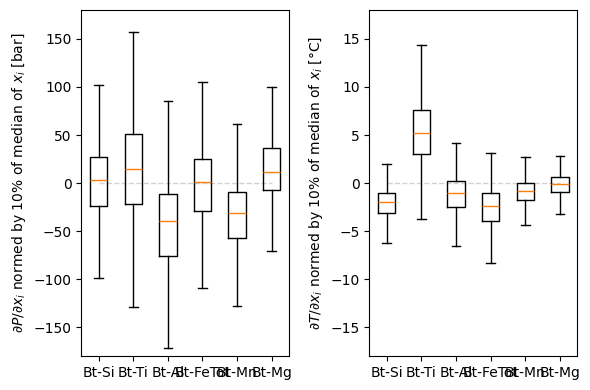

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(6, 4))

axs[0].hlines(0, 1, 6, colors="lightgrey", linestyles="--", lw=1)

axs[0].boxplot(dir_grad_P, showfliers=False)
axs[0].set_ylim(-180, 180)
axs[0].set_ylabel("$\partial P / \partial x_i$ normed by 10% of median of $x_i$ [bar]")
axs[0].set_xticks(range(1, 7))
axs[0].set_xticklabels(["Bt-Si", "Bt-Ti", "Bt-Al", "Bt-FeTot", "Bt-Mn", "Bt-Mg"])

axs[1].hlines(0, 1, 6, colors="lightgrey", linestyles="--", lw=1)

axs[1].boxplot(dir_grad_T, showfliers=False)
axs[1].set_ylim(-18, 18)
axs[1].set_ylabel("$\partial T / \partial x_i$ normed by 10% of median of $x_i$ [°C]")
axs[1].set_xticks(range(1, 7))
axs[1].set_xticklabels(["Bt-Si", "Bt-Ti", "Bt-Al", "Bt-FeTot", "Bt-Mn", "Bt-Mg"])

fig.tight_layout()
fig.savefig(Path("exported_figs", "pdv_grads_boxplot.pdf"), dpi=600)

In [11]:
print("Element i: Si    Ti    Al    Fe    Mn    Mg")
print("Upper quartile for P: ", np.percentile(dir_grad_P, 75, axis=0))
print("Lower quartile for P: ", np.percentile(dir_grad_P, 25, axis=0))

print("Element i: Si    Ti    Al    Fe    Mn    Mg")
print("Upper quartile for T: ", np.percentile(dir_grad_T, 75, axis=0))
print("Lower quartile for T: ", np.percentile(dir_grad_T, 25, axis=0))

Element i: Si    Ti    Al    Fe    Mn    Mg
Upper quartile for P:  [ 26.7723745   50.72302329 -10.99909877  25.07254159  -9.04593485
  36.0990801 ]
Lower quartile for P:  [-23.48924214 -21.31131231 -75.35766744 -28.98076483 -56.54548854
  -6.74654746]
Element i: Si    Ti    Al    Fe    Mn    Mg
Upper quartile for T:  [-1.06306586  7.56642166  0.20559401 -1.06703431  0.03276642  0.58946747]
Lower quartile for T:  [-3.12390697  3.03511247 -2.50988305 -3.9588012  -1.74878284 -0.91429543]


In [12]:
print("Element i: Si    Ti    Al    Fe    Mn    Mg")
print("+1.5 IQR for P: ", np.percentile(dir_grad_P, 75, axis=0) + 1.5*(np.percentile(dir_grad_P, 75, axis=0) - np.percentile(dir_grad_P, 25, axis=0)))
print("-1.5 IQR for P: ", np.percentile(dir_grad_P, 25, axis=0) - 1.5*(np.percentile(dir_grad_P, 75, axis=0) - np.percentile(dir_grad_P, 25, axis=0)))

print("Element i: Si    Ti    Al    Fe    Mn    Mg")
print("+1.5 IQR for T: ", np.percentile(dir_grad_T, 75, axis=0) + 1.5*(np.percentile(dir_grad_T, 75, axis=0) - np.percentile(dir_grad_T, 25, axis=0)))
print("-1.5 IQR for T: ", np.percentile(dir_grad_T, 25, axis=0) - 1.5*(np.percentile(dir_grad_T, 75, axis=0) - np.percentile(dir_grad_T, 25, axis=0)))

Element i: Si    Ti    Al    Fe    Mn    Mg
+1.5 IQR for P:  [102.16479945 158.77452668  85.53875422 106.15250122  62.2033957
 100.36752143]
-1.5 IQR for P:  [ -98.88166709 -129.3628157  -171.89552043 -110.06072445 -127.79481908
  -71.0149888 ]
Element i: Si    Ti    Al    Fe    Mn    Mg
+1.5 IQR for T:  [ 2.02819582 14.36338545  4.27880958  3.27061602  2.70509031  2.84511184]
-1.5 IQR for T:  [-6.21516865 -3.76185132 -6.58309862 -8.29645153 -4.42110672 -3.1699398 ]


## Plot 2: PD for each element as a function of apfu for each element, visualise as a KDE plot (?)

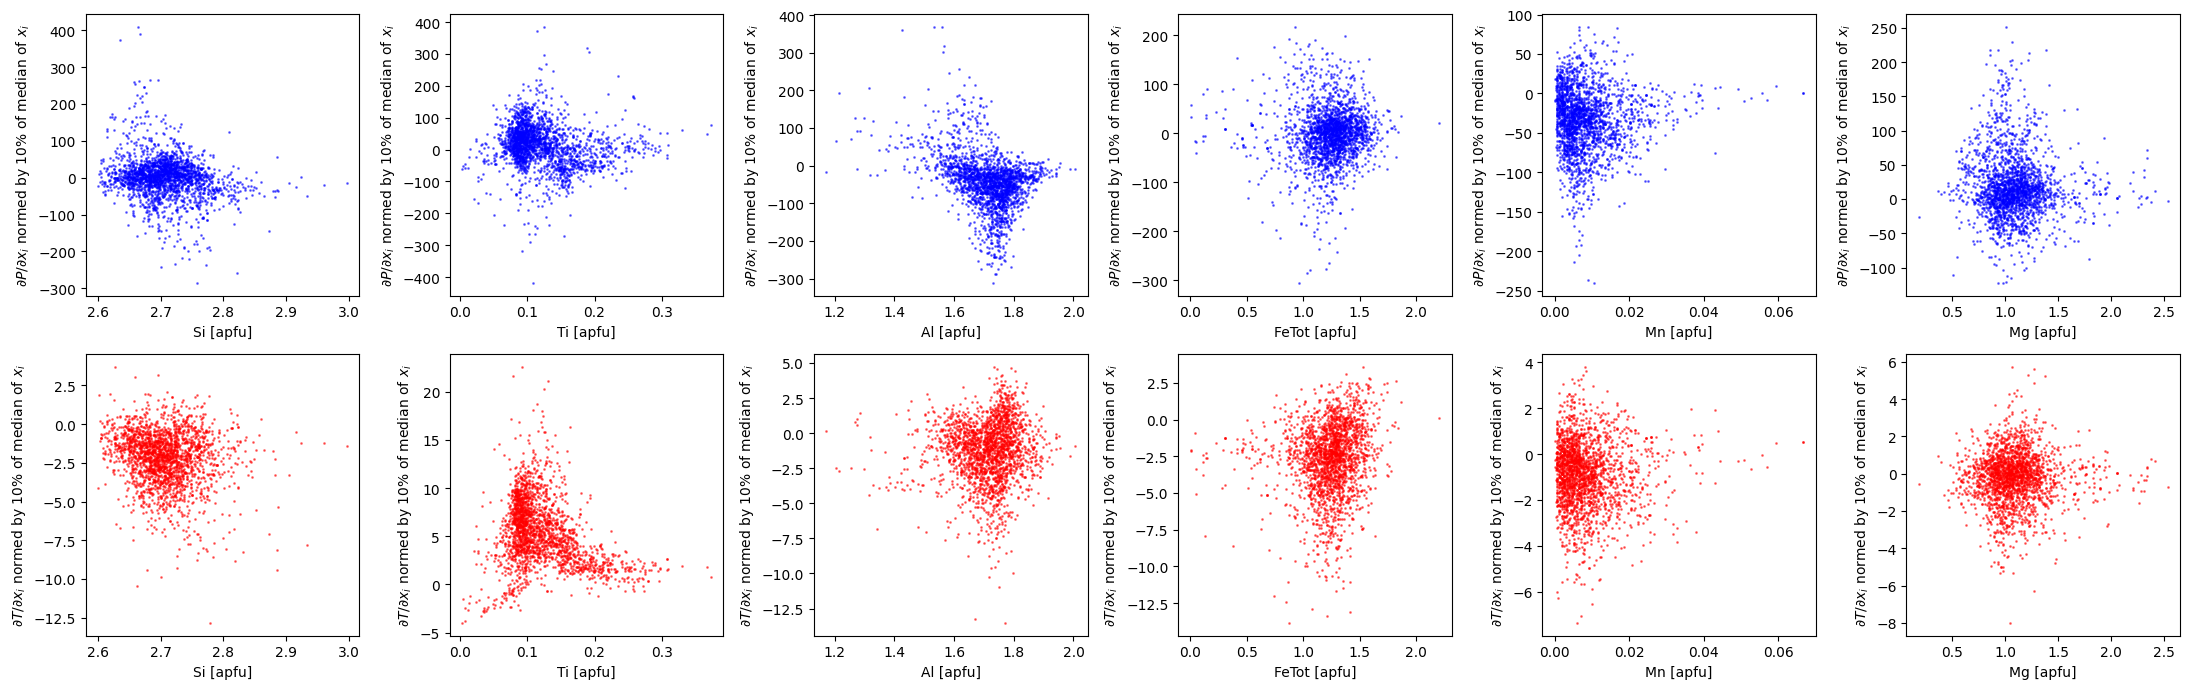

In [13]:
fig, axs = plt.subplots(2, 6, figsize=(22, 7))

for i in range(6):
    axs[0, i].scatter(biotite_composition[:, i], dir_grad_P[:, i], s=1, color="blue", alpha=0.5)
    # sns.kdeplot(x=biotite_composition[:, i], y=dir_grad_P[:, i], ax=axs[0, i], color="blue")
    axs[0, i].set_xlabel(f"{['Si', 'Ti', 'Al', 'FeTot', 'Mn', 'Mg'][i]} [apfu]")
    axs[0, i].set_ylabel("$\partial P / \partial x_i$ normed by 10% of median of $x_i$")

    axs[1, i].scatter(biotite_composition[:, i], dir_grad_T[:, i], s=1, color="red", alpha=0.5)
    # sns.kdeplot(x=biotite_composition[:, i], y=dir_grad_T[:, i], ax=axs[1, i], color="red")
    axs[1, i].set_xlabel(f"{['Si', 'Ti', 'Al', 'FeTot', 'Mn', 'Mg'][i]} [apfu]")
    axs[1, i].set_ylabel("$\partial T / \partial x_i$ normed by 10% of median of $x_i$")

fig.tight_layout()


## Plot 3: PD for elements in PT space, visualise as a heatmap

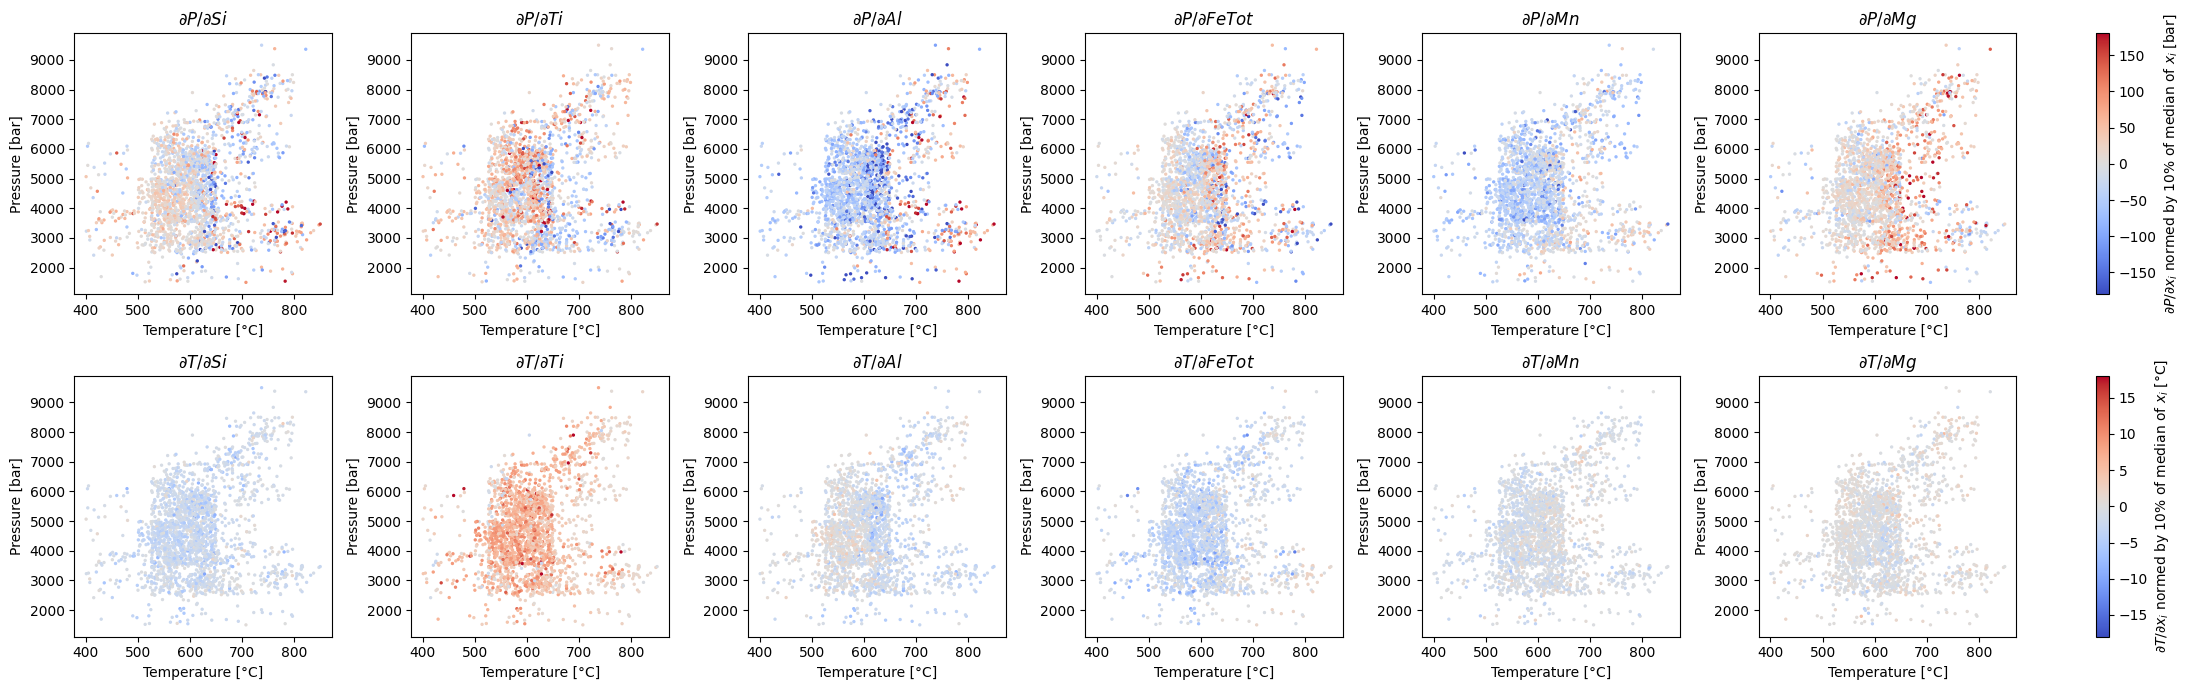

In [14]:
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec

# Create a TwoSlopeNorm object with vcenter at 0
norm_P = colors.TwoSlopeNorm(vcenter=0, vmin=-180, vmax=180)
norm_T = colors.TwoSlopeNorm(vcenter=0, vmin=-18, vmax=18)

# Create a gridspec object
gs = gridspec.GridSpec(2, 7, width_ratios=[1, 1, 1, 1, 1, 1, 0.05])

fig = plt.figure(figsize=(22, 7))

for i in range(6):
    ax = plt.subplot(gs[0, i])
    cax = ax.scatter(pt[:, 1], pt[:, 0], c=dir_grad_P[:, i], cmap="coolwarm", s=2, norm=norm_P)
    ax.set_xlabel("Temperature [°C]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_title(f"$\partial P / \partial {['Si', 'Ti', 'Al', 'FeTot', 'Mn', 'Mg'][i]}$")

    if i == 5:
        cbar_ax = plt.subplot(gs[0, -1])
        fig.colorbar(cax, cax=cbar_ax, label="$\partial P / \partial x_i$ normed by 10% of median of $x_i$ [bar]")

    ax = plt.subplot(gs[1, i])
    cax = ax.scatter(pt[:, 1], pt[:, 0], c=dir_grad_T[:, i], cmap="coolwarm", s=2, norm=norm_T)
    ax.set_xlabel("Temperature [°C]")
    ax.set_ylabel("Pressure [bar]")
    ax.set_title(f"$\partial T / \partial {['Si', 'Ti', 'Al', 'FeTot', 'Mn', 'Mg'][i]}$")

    if i == 5:
        cbar_ax = plt.subplot(gs[1, -1])
        fig.colorbar(cax, cax=cbar_ax, label="$\partial T / \partial x_i$ normed by 10% of median of $x_i$ [°C]")

fig.tight_layout()

Detail views for main body thesis

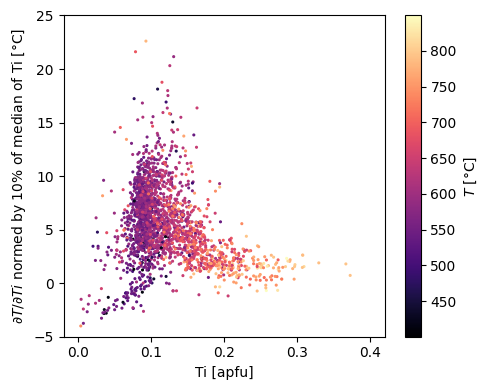

In [15]:
fig, ax = plt.subplots(figsize=(5, 4))

cax = ax.scatter(biotite_composition[:, 1], dir_grad_T[:, 1], s=1.5, c=pt[:, 1], cmap="magma")
ax.set_xlabel("Ti [apfu]")
ax.set_ylabel("$\partial T / \partial Ti$ normed by 10% of median of Ti [°C]")

ax.set_xlim(-0.02, 0.42)
ax.set_ylim(-5, 25)

fig.colorbar(cax, label="$T$ [°C]")

fig.tight_layout()
fig.savefig(Path("exported_figs", "gradient_T_Ti.pdf"), dpi=600)

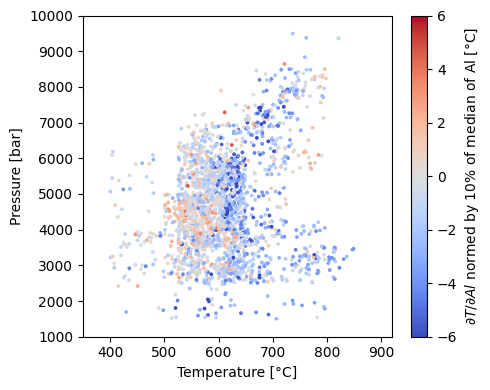

In [16]:
# Create a TwoSlopeNorm object with vcenter at 0 and min max for Al
norm_T_Al = colors.TwoSlopeNorm(vcenter=0, vmin=-6, vmax=6)

fig, ax = plt.subplots(figsize=(5, 4))

cax = ax.scatter(pt[:, 1], pt[:, 0], c=dir_grad_T[:, 2], cmap="coolwarm", s=3, norm=norm_T_Al)

ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Pressure [bar]")

ax.set_xlim(350, 920)
ax.set_ylim(1000, 10000)

fig.colorbar(cax, label="$\partial T / \partial Al$ normed by 10% of median of Al [°C]")

fig.tight_layout()
fig.savefig(Path("exported_figs", "gradient_T_Al_PT.pdf"), dpi=600)

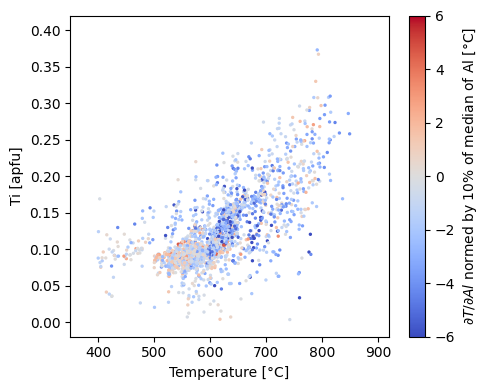

In [17]:
# Create a TwoSlopeNorm object with vcenter at 0 and min max for Al
norm_T_Al = colors.TwoSlopeNorm(vcenter=0, vmin=-6, vmax=6)

fig, ax = plt.subplots(figsize=(5, 4))

cax = ax.scatter(pt[:, 1], biotite_composition[:, 1], c=dir_grad_T[:, 2], cmap="coolwarm", s=2, norm=norm_T_Al)

ax.set_xlabel("Temperature [°C]")
ax.set_ylabel("Ti [apfu]")

ax.set_xlim(350, 920)
ax.set_ylim(-0.02, 0.42)

fig.colorbar(cax, label="$\partial T / \partial Al$ normed by 10% of median of Al [°C]")

fig.tight_layout()